In [23]:
import glob
import nibabel as nib
import pandas as pd
import seaborn as sns
import nilearn
from nilearn import plotting
from nilearn import image
import numpy as np
from scipy.io import loadmat
from scipy import stats
import os
import multiprocessing as mp

In [7]:
# Load Subjects' data
cov_path = '/media/2Tb/functional_analysis_jan2021/conn_covs.csv'
data = pd.read_csv(cov_path)

In [8]:
data.head()

,CONN_ID,CONN_sub_ID,ID,diag
0,1,1,sub-NeuroMET003,2.0
1,2,2,sub-NeuroMET004,0.0
2,3,3,sub-NeuroMET006,0.0
3,4,4,sub-NeuroMET007,1.0
4,5,5,sub-NeuroMET008,0.0


In [9]:
mat = loadmat('/media/2Tb/functional_analysis_jan2021/NeuroMet_fmriprep_conn/results/firstlevel/MRS_Voxel_to_Voxel/_list_sources.mat')

In [10]:
mat['sourcenames']

array([[array(['MRS_Voxel'], dtype='<U9'),
        array(['MRS_Voxel_MNI2009'], dtype='<U17')]], dtype=object)

In [11]:
# We need the 2nd one

In [19]:
# Grab all MRS-Voxel-to-whole-Brain connectivity maps niftis
#s1_beta_path = glob.glob('/media/2Tb/functional_analysis_jan2021/NeuroMet_fmriprep_conn/results/firstlevel/MRS_Voxel_to_Voxel/BETA_Subject*_Condition001_Source002.nii')
beta_paths_mask = '/media/2Tb/functional_analysis_jan2021/NeuroMet_fmriprep_conn/results/firstlevel/MRS_Voxel_to_Voxel/BETA_Subject{num}_Condition001_Source002.nii'
data['BETA_paths'] = [beta_paths_mask.format(num=str(i).zfill(3)) for i in data.CONN_ID]

In [20]:
# Grab all MNI registered GM masks
gm_masks_mask = '/media/2Tb/functional_analysis_jan2021/NeuroMet_fmriprep_conn/data/BIDS/dataset/sub-{num}/roi/esub-{num}_roi-GreyMatter.nii'

In [21]:
data['gm_masks'] = [gm_masks_mask.format(num=str(i).zfill(4)) for i in data.CONN_sub_ID]

In [27]:
example_img = nib.load(data['BETA_paths'][0])

In [22]:
## thresholding to 0.3 every image (corresponding p < 0.01)¶

In [25]:
%%time
def threshold_conn_map(conn_map, threshold = 0.3, subnum = 0):
    return (subnum, np.where(conn_map>threshold,conn_map,0))

threshold = 0.3
conns_thrs = list(range(subnumber)) # initialize conn list

p = mp.Pool(processes = 6)
for n in range(subnumber):
    conn_map = nib.load(data['BETA_paths'][n]).get_fdata()
    res = p.apply_async(threshold_conn_map, (conn_map, threshold, n)).get()
    conns_thrs[res[0]] = res[1]
    #print('{}: done'.format(res[0]))

CPU times: user 9.61 s, sys: 13 s, total: 22.6 s
Wall time: 50.6 s


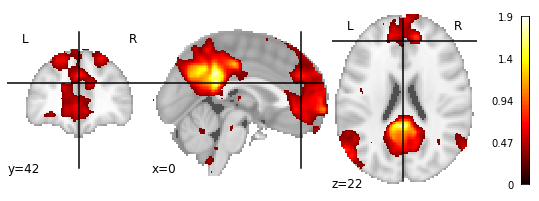

In [58]:
# Plot a thresholded conn_map
i = conns_thrs[12]
plotting.plot_stat_map(nib.Nifti1Image(i, example_img.affine, header=example_img.header), cut_coords=(0,42,22),colorbar=True)

In [31]:
#np.savez('./conns_thrs.npz', conns_thrs=conns_thrs)

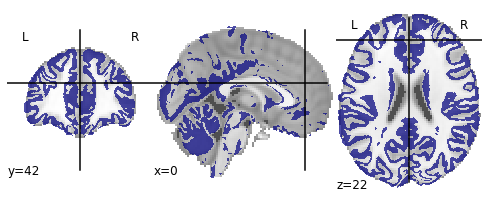

In [40]:
j = data.gm_masks[12]
plotting.plot_roi(j, cut_coords=(0,42,22))

In [71]:
%%time
def multiply_nii(nii1, nii2, subnum = 0):
    return (subnum, nii1 * nii2)

conns_masked = list(range(subnumber)) # initialize conn list

p = mp.Pool(processes = 6)
for n in range(subnumber):
    conn_map = conns_thrs[n]
    gm_mask = nib.load(data['gm_masks'][n]).get_fdata()
    res = p.apply_async(multiply_nii, (conn_map, gm_mask, n)).get()
    conns_masked[res[0]] = res[1]
    #print('{}: done'.format(res[0]))

CPU times: user 12.6 s, sys: 15min 46s, total: 15min 58s
Wall time: 15min 48s


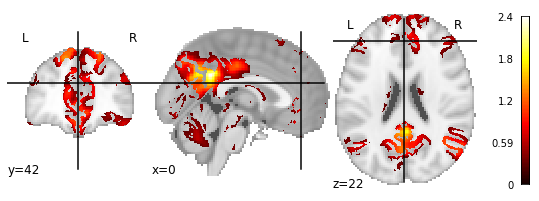

In [72]:
k = conns_masked[18]
plotting.plot_stat_map(nib.Nifti1Image(k, example_img.affine, header=example_img.header), cut_coords=(0,42,22),colorbar=True)

In [73]:
%%time
def make_mean(arr, subnum = 0):
    non_zero = arr[arr != 0].shape[0]
    return (subnum, arr.sum()/non_zero)


masked_means = list(range(subnumber)) # initialize conn list

p = mp.Pool(processes = 6)
for n in range(subnumber):
    res = p.apply_async(make_mean, (conns_masked[n], n)).get()
    masked_means[res[0]] = res[1]
    #print('{}: done'.format(res[0]))

CPU times: user 2.55 s, sys: 25.7 s, total: 28.2 s
Wall time: 27.1 s


In [74]:
data['masked_means'] = masked_means

<AxesSubplot:>

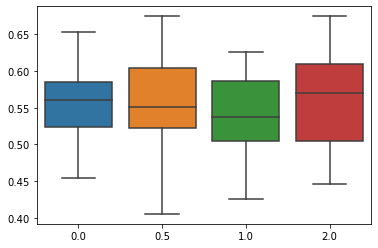

In [75]:
sns.boxplot(y=data.masked_means.values, x=data.diag.values)

<AxesSubplot:>

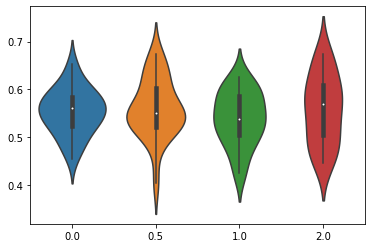

In [76]:
sns.violinplot(y=data.masked_means.values, x=data.diag.values)

In [84]:
np.savez('./GSH_seed_to_voxel.npz', conns_masked=conns_masked)

In [85]:
data.to_csv('GSH_seed_to_voxel.csv')